In [1]:
import torch
import torch.nn as nn

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
# Build the dataset

block_size = 6 # Context Length: How many characters do we take to predict the next one?
X,Y = [], []

for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # Crop and Append

xs = torch.tensor(X)
targets = torch.tensor(Y)
num = len(Y)

In [5]:
# Split data
num_samples = xs.shape[0]

# 70/15/15 split (or 80/10/10)
train_end = int(0.7 * num_samples)
val_end = int(0.85 * num_samples)

# DO NOT SHUFFLE YET
xs_train = xs[:train_end]
ys_train = targets[:train_end]

xs_val = xs[train_end:val_end]
ys_val = targets[train_end:val_end]

xs_test = xs[val_end:]
ys_test = targets[val_end:]

perm = torch.randperm(xs_train.shape[0])
xs_train = xs_train[perm]
ys_train = ys_train[perm]

In [6]:
class Gate(nn.Module):
    def __init__(self, in_size, hidden_size):
        super().__init__()
        self.in_weight = nn.Parameter(torch.randn((in_size, hidden_size), requires_grad=True) / torch.sqrt(torch.tensor(in_size)))
        self.hidden_weight = nn.Parameter(torch.randn((hidden_size, hidden_size), requires_grad=True) / torch.sqrt(torch.tensor(hidden_size)))
        self.bias = nn.Parameter(torch.zeros((hidden_size,), requires_grad=True))
        self.act = torch.sigmoid
        
    def forward(self, x_inp, hidden_inp):
        unact = hidden_inp @ self.hidden_weight + x_inp @ self.in_weight + self.bias
        return self.act(unact)

In [7]:

class Cell(nn.Module):
    def __init__(self, in_size, hidden_size):
        super().__init__()
        self.forget_gate = Gate(in_size, hidden_size)
        self.input_gate = Gate(in_size, hidden_size)
        self.out_gate = Gate(in_size, hidden_size)
        self.inp_weight = nn.Parameter(torch.randn((in_size, hidden_size), requires_grad=True) / torch.sqrt(torch.tensor(in_size)))
        self.hidden_weight = nn.Parameter(torch.randn((hidden_size, hidden_size), requires_grad=True) / torch.sqrt(torch.tensor(hidden_size)))
        self.bias = nn.Parameter(torch.zeros((hidden_size,), requires_grad=True))
    
    def forward(self, x_inp, hidden_inp, memory_inp):
        forget_gate = self.forget_gate(x_inp, hidden_inp)
        input_gate = self.input_gate(x_inp, hidden_inp)
        out_gate = self.out_gate(x_inp, hidden_inp)


        candidate_mem = torch.tanh(hidden_inp @ self.hidden_weight + x_inp @ self.inp_weight + self.bias)
        new_mem = forget_gate * memory_inp + input_gate * candidate_mem
        new_output = out_gate * torch.tanh(new_mem)
        return (new_output, new_mem)

In [8]:
# Feature dim is always last dim
class BatchNorm1D(nn.Module):
    def __init__(self, num_features, _momentum=0.9):
        super().__init__()
        self.running_mu = torch.ones((num_features,))
        self.running_var = torch.zeros((num_features,))
        self.gamma = nn.Parameter(torch.ones((num_features,), requires_grad=True))
        self.beta = nn.Parameter(torch.zeros((num_features,), requires_grad=True))
        self.momentum = _momentum
    
    def forward(self, inp: torch.Tensor):
        ndims = inp.ndim - 1
        c = self.running_mu.shape[0]
        if self.training:
            shape = tuple(range(0, ndims))
            mu = torch.mean(inp, dim=shape, keepdim=True)
            var = torch.var(inp, dim=shape, keepdim=True, correction=0.0)
        else:
            mu = self.running_mu.view(*([1] * ndims), c)
            var = self.running_var.view(*([1] * ndims), c)
        
        gamma = self.gamma.view(*([1] * ndims), c)
        beta = self.beta.view(*([1] * ndims), c)

        # Normalize then reparametrize
        x_hat = (inp - mu) / torch.sqrt(var + 1e-12)
        x_new = gamma * x_hat + beta

        # Update running average -- if training
        if self.training:
            self.running_mu = self.momentum * self.running_mu + (1 - self.momentum) * mu.squeeze()
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var.squeeze()
        
        return x_new

In [9]:
class LSTM(nn.Module):
    def __init__(self, in_size, hidden_size, training=True):
        super().__init__()
        self.cell = Cell(in_size, hidden_size)
        if self.training: # Batch mode
            self.initial_hidden = torch.zeros((1, hidden_size))
            self.initial_mem = torch.zeros((1, hidden_size))
        else:
            self.initial_hidden = torch.zeros(hidden_size)
            self.initial_mem = torch.zeros(hidden_size)
        
        self.in_batchnorm = BatchNorm1D(in_size)
        self.hidden_batchnorm = BatchNorm1D(hidden_size)
        self.training = training
    
    def forward(self, inp: torch.Tensor):
        hidden = self.initial_hidden
        mem = self.initial_mem
        if inp.ndim == 2:
            channels = inp.shape[0]
        elif inp.ndim == 3:
            channels = inp.shape[1]
        else:
            raise ValueError
        
        for t in range(channels):
            # Ensure no batchnorm bugs
            if self.training != self.in_batchnorm.training:
                self.in_batchnorm.training = self.training
            if self.training != self.hidden_batchnorm.training:
                self.hidden_batchnorm.training = self.training

            # Deal with dimension cases
            if inp.ndim == 2:
                x = self.in_batchnorm(inp[t, :])
            else:
                x = self.in_batchnorm(inp[:, t, :])
            # Cell update
            hidden = self.hidden_batchnorm(hidden)
            hidden, mem = self.cell(x, hidden, mem)
        return hidden

In [ ]:
class MLP(nn.Module):
    def __init__(self, size: tuple, training=True):
        super().__init__()
        self.layers = nn.Sequential()
        for l1, l2 in zip(size, size[1:]):
            self.layers.append(nn.Linear(l1, l2))
            self.layers.append(nn.Tanh())
            self.layers.append(nn.Dropout(0.5))
        self.layers.pop(-1)
        self.training=training
    
    def forward(self, inp):
        return self.layers.forward(inp)

In [11]:
class VFNN(nn.Module):
    def __init__(self, hidden_size: int, inp_size: int, MLP_size: tuple, training=True):
        super().__init__()
        self.blocks = nn.Sequential()
        emb = nn.Embedding(27, inp_size)
        self.blocks.append(emb)
        lstm = LSTM(in_size=inp_size, hidden_size=hidden_size)
        self.blocks.append(lstm)
        mlp = MLP(MLP_size)
        self.blocks.append(mlp)
        self.training = training
    
    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        logits = self.blocks.forward(inp)
        return logits

In [12]:
def sgd(model: VFNN, xs: torch.Tensor, ys: torch.Tensor, lr: float = 0.1, batch_size: int = 30, steps: int = 1000):
    """
    Perform stochastic gradient descent on model
    """
    lossi = []
    for step in range(steps):
        idx = torch.randint(0, len(xs), (batch_size,))
        x_batch, y_batch = xs[idx], ys[idx]

        logits = model.forward(x_batch)
        loss = nn.functional.cross_entropy(logits, y_batch)

        l2_lambda = 1e-4
        l2_penalty = torch.tensor(0.0)
        for param in model.parameters():
            param.grad = None
            l2_penalty += (param * param).sum()

        loss = loss + l2_lambda * l2_penalty

        loss.backward()
        lossi.append(loss.log10().item())
        

        for param in model.parameters():
            param.grad = param.grad.clamp(-5, 5)
            param.data += -lr * param.grad
    
        if step == steps // 2:
            lr = lr * 0.1

        if step % 100 == 0:
            print(f"Loss: {loss.item()} on step: {step + 1}")
    return lossi

In [13]:
model = VFNN(64, 32, (64, 128,  27))

Loss: 1.8696414232254028 on step: 1
Loss: 2.0106723308563232 on step: 101
Loss: 2.304224729537964 on step: 201
Loss: 1.5995361804962158 on step: 301
Loss: 2.2020530700683594 on step: 401
Loss: 1.8467884063720703 on step: 501
Loss: 2.3253800868988037 on step: 601
Loss: 1.840749740600586 on step: 701
Loss: 2.150315523147583 on step: 801
Loss: 1.8765538930892944 on step: 901


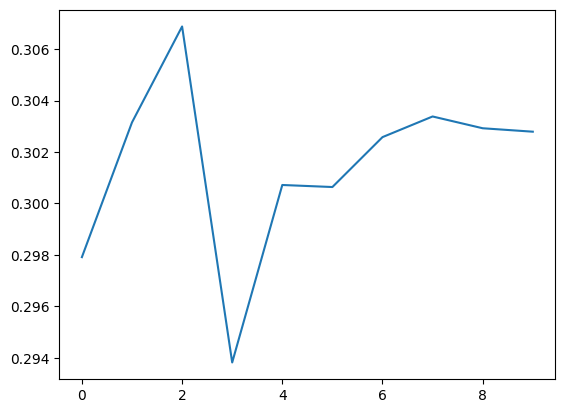

In [32]:
model.train()
lossi = sgd(model, xs_train, ys_train, lr=0.01, batch_size=60, steps=1000)
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [33]:
model.eval()
logits = model.forward(xs_val)
loss = nn.functional.cross_entropy(logits, ys_val)
print(loss.item())

2.4033620357513428


In [37]:
# Testing Output
for k in range(10):
    prev = [0] * block_size
    
    out = []
    while True:
        logits = model.forward(torch.tensor(prev))
        counts = logits.exp()
        probs = counts / counts.sum()

        idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        
        if idx == 0:
            break
        out.append(itos[idx])
        prev = prev[1:] + [idx]
    print(''.join(out).capitalize())

Vansey
Laylani
Novel
Dipe
Rheale
Nouirika
Emmariela
Azlah
Andrie
Elahmi
